<a href="https://colab.research.google.com/github/xurror/365-days-of-code/blob/master/Animal_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks**

---


## **Project: Write an Algorithm to classify 5 classes of animals**

### **Why We're Here**
In this notebook, we will be building an animal classifier. This classifier is a model that can tell if a provided animal image corresponds to our sorted animal classes by giving the estimate of the animal class.

**Tools Used**
 - Pytthon
 - Pytorch
 - Matplotlib
 - numpy
 - [Google Colab](https://colab.research.google.com)

In this real-world setting, we will to piece together a series of models to perform different tasks.

- Step 0: Import Datasets
- Step 1: Setup some functions
- Step 2: Detect Dogs
- Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
- Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
- Step 5: Write your Algorithm
- Step 6: Test Your Algorithm

Step 0: Import Datasets
Make sure that you've downloaded the required human and dog datasets:

Download the dog dataset. Unzip the folder and place it in this project's home directory, at the location /dogImages.

Download the human dataset. Unzip the folder and place it in the home directory, at location /lfw.

Note: If you are using a Windows machine, you are encouraged to use 7zip to extract the folder.

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays human_files and dog_files.

# **Step0: Data Extraction**
---
- Download the dataset Extract dataset
 > Dataset was gotten from kaggle([Animals10 dataset](https://www.kaggle.com/alessiocorrado99/animals10)
 Dataset contains 10 classes of animals(dog, cat, horse, elephant, squirrel, sheep, butterfly, chicken, cow, spider) for a total of about 28k images
- Sort the required classes
  > For this project, we have sliced this dataset to reduce it to 5 giving up a total of *9617* images classes which are:
    - horse
    - Elephant
    - cow
    - sheep
    - squirrel



In [1]:
!rm -rf data
!rm -rf downloads
!rm translate.py
!rm animals10.zip

!cp -rf drive/My\ Drive/datasets/test_imgs /content
!cp /content/drive/My\ Drive/datasets/animals10.zip /content
!unzip animals10.zip

!mv raw-img data

!rm -rf data/cane data/gatto data/farfalla data/scoiattola data/ragno data/gallina

!mv data/cavallo data/horse
!mv data/elefante data/elephant
!mv data/mucca data/cow
!mv data/pecora data/sheep
!mv data/scoiattolo data/squirrel

!du -sh data

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3Xbf3ulUg4DQ_EwHaFz.jpeg  
  inflating: raw-img/ragno/OIP-Mj15wALS_srxPktt6trhhQHaGA.jpeg  
  inflating: raw-img/ragno/OIP-Mj_JhYsl

In [2]:
import os

path, dirs, horse = next(os.walk("data/horse"))
path, dirs, elephant = next(os.walk("data/elephant"))
path, dirs, cow = next(os.walk("data/cow"))
path, dirs, sheep = next(os.walk("data/sheep"))
path, dirs, squirrel = next(os.walk("data/squirrel"))

print('There are %d total horse images.' % len(horse))
print('There are %d total elephant images.' % len(elephant))
print('There are %d total cow images.' % len(cow))
print('There are %d total sheep images.' % len(sheep))
print('There are %d total squirrel images.' % len(squirrel))
print("\n Total dataset size: " + str(len(horse) + len(elephant) + len(cow) + len(sheep) + len(squirrel)))

There are 2623 total horse images.
There are 1446 total elephant images.
There are 1866 total cow images.
There are 1820 total sheep images.
There are 1862 total squirrel images.

 Total dataset size: 9617


In [89]:
## Imports
import os
import cv2
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

# **Step1: Setup some functions**

Setup functions to split dataset into training, validation and testing sets

In [116]:
label_names = [
    'cow',
    'elephant',
    'horse',
    'sheep',
    'squirrel'
]


def plot_images(images, cls_true, cls_pred=None):
    fig, axes = plt.subplots(3, 3, figsize=(6,6))

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over our dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.Resize(size=(224,224)),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize(size=(224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=train_transform)
    valid_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        print("Train images after augmentation")
        plot_images(X, labels)

    return (train_loader, valid_loader)

def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    show_sample=False,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process
    test iterator over our dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # define transform
    transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        print("Test images after augmentation")
        plot_images(X, labels)

    return data_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train images after augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


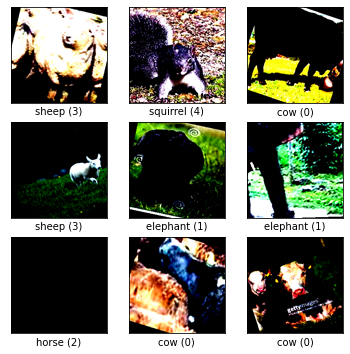

Test images after augmentation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


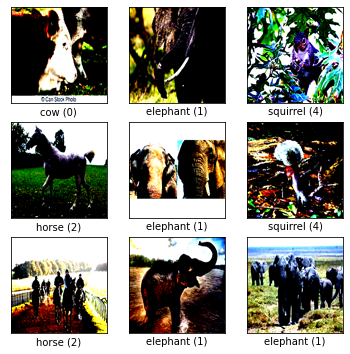

In [117]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

batch_size = 32

train_loader, valid_loader = get_train_valid_loader(data_dir="data", batch_size=batch_size, augment=True, random_seed=8, show_sample=True)
test_loader = get_test_loader(data_dir="data", batch_size=batch_size, show_sample=True)

# **Step : Model From Scratch**

### (IMPLEMENTATION) Model Architecture

While building this model we took into account certain very important factors. We had alot of concerns for things like **underfitting** and **overfitting**

  1. ** Overfitting**
  > - Overfitting is a scenario where your model performs well on training data but performs poorly on data not seen during training. This basically means that your model has memorized the training data instead of learning the relationships between features and labels.
    - Overfitting is easy to diagnose with the accuracy visualizations you have available. If "Accuracy" (measured against the training set) is very good and "Validation Accuracy" (measured against a validation set) is not as good, then your model is overfitting.


  2. **Underfitting**
  > - Underfitting is the opposite counterpart of overfitting wherein your model exhibits high bias. This situation can occur when your model is not sufficiently complex to capture the relationship between features and labels (or if your model is too strictly regularized).
    - Underfitting is a bit harder to diagnose. If Accuracy and Validation Accuracy are similar but are both poor, then you may be underfitting.

In order to obtain an average best performance, we had to build an architecture that is simple enough to prevent our model from cramming(overfitting) and to make sure that the model is smart enough to capture the relationship between features and characteristics of the provided input.

In [134]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128*56*56, 512, bias=True)
        self.fc2 = nn.Linear(512, 256, bias=True)
        self.fc3 = nn.Linear(256, 5, bias=True)

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # print(x.shape)

        x = x.view(-1, 128*56*56)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x
if use_cuda:
    net = Net().cuda()
else:
    net = Net()
net

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax()
)

In [135]:
# The negative log likelihood loss. It is useful to train a classification problem with C classes.
criterion_scratch = nn.NLLLoss()
optimizer_scratch = torch.optim.SGD(net.parameters(), lr = 0.001, momentum= 0.9)

In [136]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        #i = 0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        #print(f'train - output: {output}    target: {target}')
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        #print(f'valid - output: {output}    target: {target}')
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

### TRAINING

Training params:
 - learning_rate = 0.03
 - Loss function = NLLLoss(Negative Log Likelihood Loss
 - Optimizer: SGD(Stochrastic Gradient Descent)
 - Epochs: 60
 - Batch Size: 32

In [137]:
# train the model
model_scratch = train(100, train_loader, valid_loader, net, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'nnew_animal_classifier.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('nnew_animal_classifier.pt'))

Epoch: 1 	Training Loss: 1.539503 	Validation Loss: 1.421458
Validation loss decreased (inf --> 1.421458).  Saving model ...
Epoch: 2 	Training Loss: 1.465908 	Validation Loss: 1.372392
Validation loss decreased (1.421458 --> 1.372392).  Saving model ...
Epoch: 3 	Training Loss: 1.418162 	Validation Loss: 1.392466
Epoch: 4 	Training Loss: 1.385721 	Validation Loss: 1.294998
Validation loss decreased (1.372392 --> 1.294998).  Saving model ...
Epoch: 5 	Training Loss: 1.362673 	Validation Loss: 1.279684
Validation loss decreased (1.294998 --> 1.279684).  Saving model ...
Epoch: 6 	Training Loss: 1.330190 	Validation Loss: 1.267769
Validation loss decreased (1.279684 --> 1.267769).  Saving model ...
Epoch: 7 	Training Loss: 1.297788 	Validation Loss: 1.298449
Epoch: 8 	Training Loss: 1.297849 	Validation Loss: 1.207348
Validation loss decreased (1.267769 --> 1.207348).  Saving model ...
Epoch: 9 	Training Loss: 1.268311 	Validation Loss: 1.161434
Validation loss decreased (1.207348 --> 1.

<All keys matched successfully>

In [138]:
def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### TESTING

In [139]:
# call test function
model_scratch.load_state_dict(torch.load('nnew_animal_classifier.pt'))
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.421036


Test Accuracy: 84% (8155/9617)


In [140]:
net.load_state_dict(torch.load('nnew_animal_classifier.pt'))

<All keys matched successfully>

In [141]:
model = net.cpu()

### REALLIFE TESTING

Here the model is tested with some random images and the probability mapped on a bar chart and class predicted.

In [142]:
import time
def classify(img_path):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    classes = ['cow', 'elephant', 'horse', 'sheep', 'squirrel']
    img_raw = Image.open(img_path)
    transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
    ])
    
    img = transform(img_raw)
    img = torch.unsqueeze(img, 0)

    # Turn off gradients to speed up this part
    with torch.no_grad():
        output = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    pb = torch.exp(output)
    probab = list(pb.numpy()[0])

    actual_class = ''

    for aclass in classes:
        if aclass in img_path:
            actual_class = aclass

    fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)
    ax1.imshow(img_raw)
    ax1.set_title('Predicted Class: ' + classes[probab.index(max(probab))])
    ax1.axis('off')

    ax2.barh(classes, probab)
    ax2.set_aspect(0.1)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [148]:
!rm -rf elites
!cp -rf /content/drive/My\ Drive/datasets/elites /content

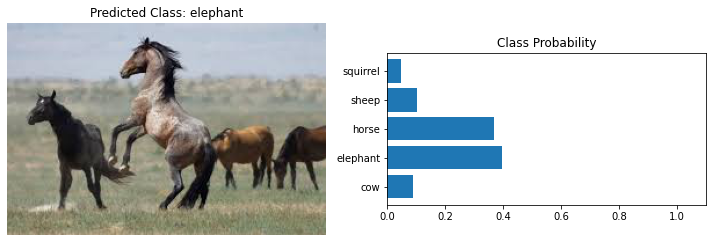

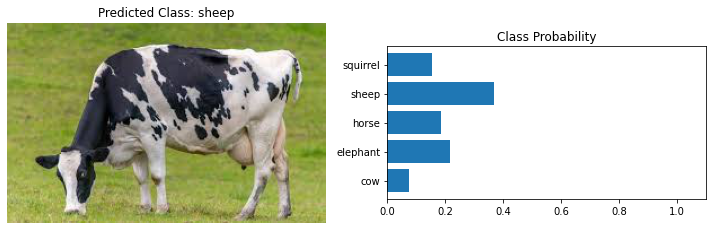

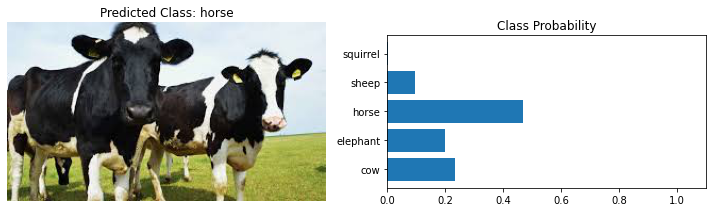

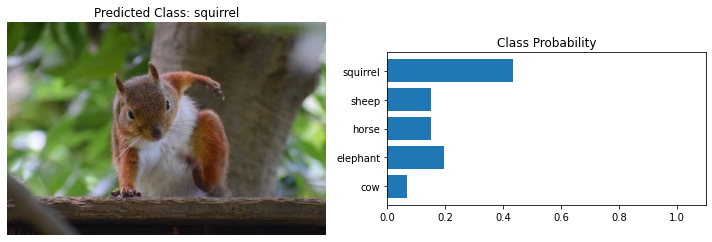

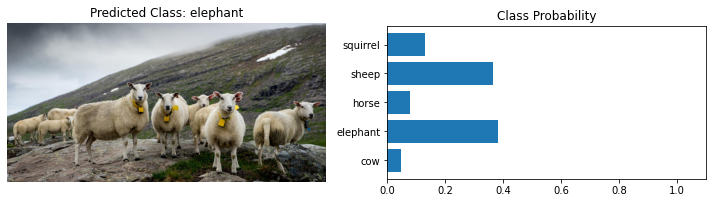

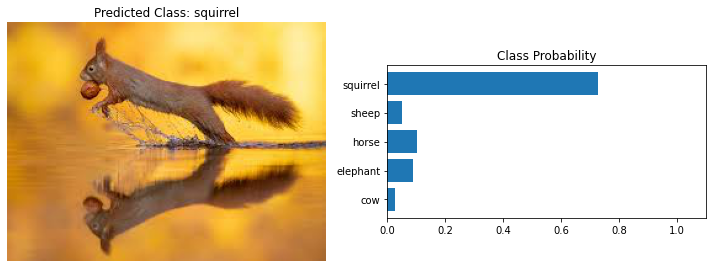

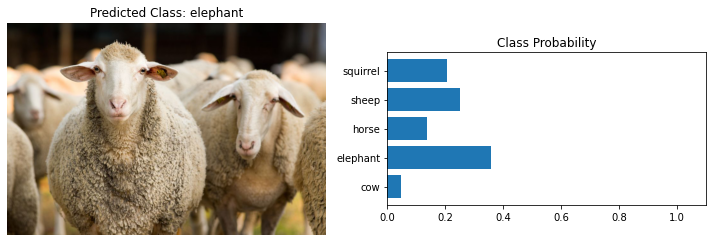

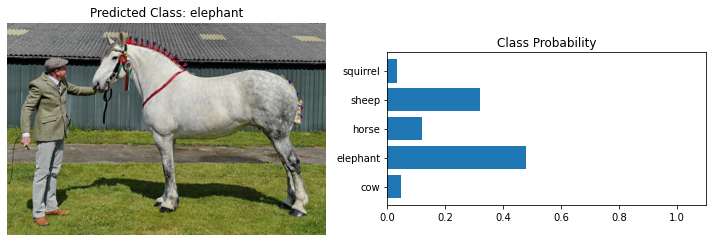

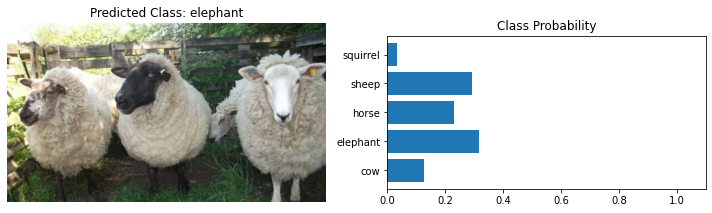

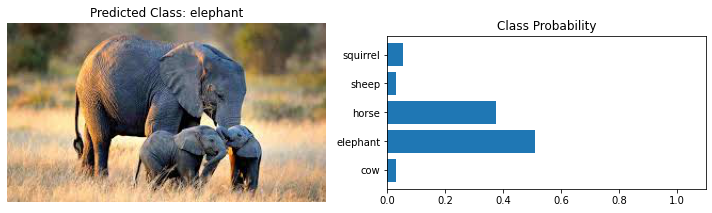

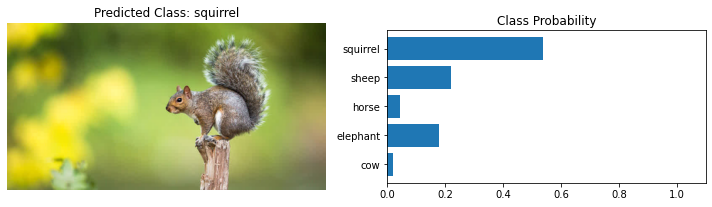

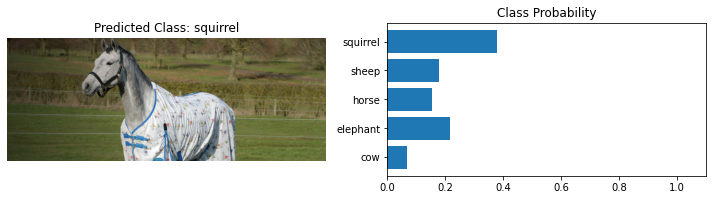

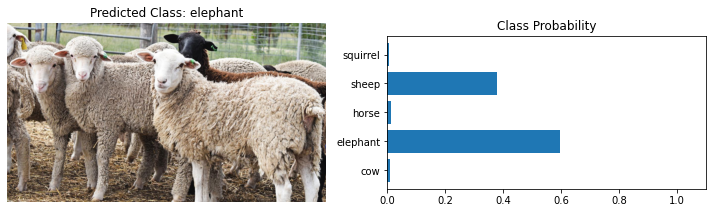

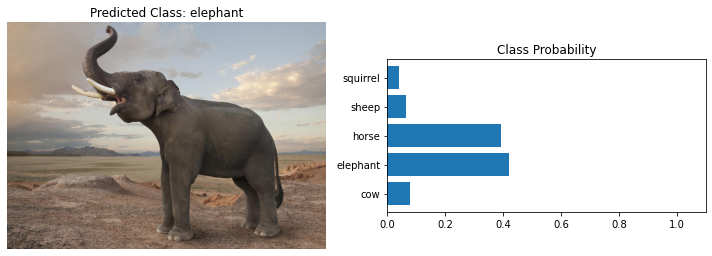

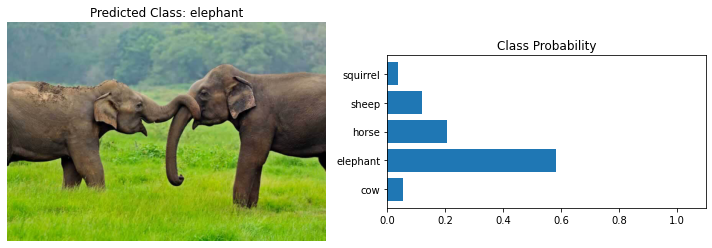

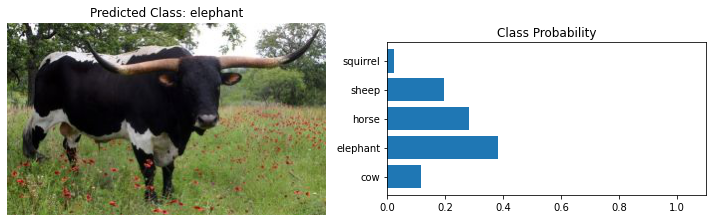

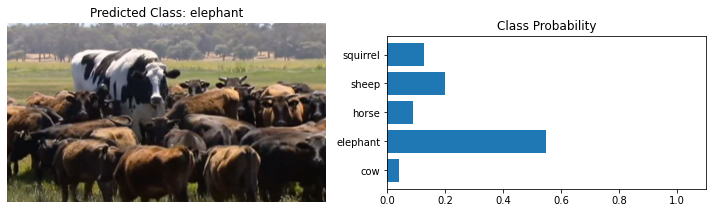

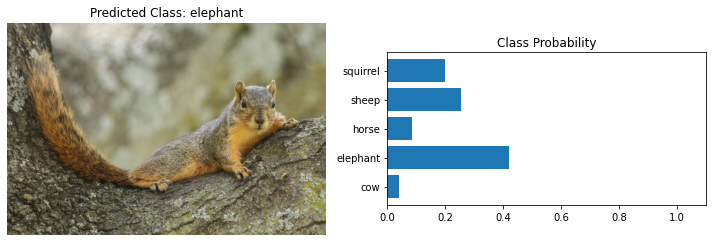

In [149]:
directory = 'elites'

for filename in os.listdir(directory):
    classify(directory + '/' + filename)

In [86]:
!du -sh new_animal_classifier.pt

785M	new_animal_classifier.pt


# **CONCLUSION**

Our animal classifier wasa able to achieve an accuracy of *84%* with the least compromise possible. Some level of cramming can be observed though. 